## Clustering + PCA code
### TODO: Try to cluster without label (methoddeath), and then see how they corrospond

In [2]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ["RedCapID", 'CaseCtrl', 'indexredcapid', 'Female', 'Age', 'Race',
       'Spanish', 'Month_Birth', 'Year_Birth', 'Month_Death',
       'Year_Death', 'EducationMax', 'EgoMaritalStatus', 'methoddeath',
       'violent']
# df = pd.read_csv('data/Test_Data_1102_enumerated.csv')
dffull = pd.read_csv('./data/Test_Data_1102_enumerated_filledin.csv')

In [120]:
# paring down features for this run
print(dffull.shape)
dfrows = dffull#[dffull.CaseCtrl != 0] #tried without control cases, didn't cluster well
df = dfrows.drop(columns = ['RedCapID', 'CaseCtrl', 'indexredcapid',  'Month_Birth', 'Year_Birth', 'Month_Death','Year_Death', 'methoddeath'])
print(df.shape)
print(df.columns.values)

(25489, 148)
(25489, 140)
['Female' 'Age' 'Race' 'Spanish' 'EducationMax' 'EgoMaritalStatus'
 'violent' '276.5' '401.1' '250.2' '208.0' '318.0' '296.22' '761.0'
 '530.11' '300.1' '475.0' '465.0' '465.2' '840.0' '841.0' '835.0' '495.0'
 '296.2' '483.0' '773.0' '1009.0' '464.0' '591.0' '316.0' '285.0' '276.14'
 '296.1' '726.0' '665.0' '244.4' '317.1' '785.0' '561.1' '760.0' '745.0'
 '783.0' '512.9' '558.0' '830.0' '300.4' '916.0' '789.0' '480.0' '798.0'
 '216.0' '339.0' '939.0' '512.8' '300.0' '915.0' '819.0' '722.1' '418.0'
 '1010.0' '535.9' '455.0' '272.1' '722.6' '296.0' '479.0' '340.0' '721.1'
 '300.11' '457.0' '272.11' '351.0' '804.0' '278.1' '740.9' '512.7'
 '276.41' '593.0' '295.3' '870.3' '291.8' '740.1' '386.9' '687.4' '771.1'
 '532.0' '338.2' '600.0' '426.7' '297.2' '345.3' '788.0' '871.0' '427.3'
 '563.0' '317.0' '300.9' '327.3' '313.1' '530.1' '871.2' '300.12' '301.0'
 '338.1' '782.3' '967.0' '327.32' '276.12' '497.0' '979.0' '306.0' '327.4'
 '809.0' '716.9' '508.0' '585.1' '

In [121]:
## Standardize scores so PCA won't just weight the larger numbers
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df)

In [122]:
#fit pca
pca = PCA()
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'Cumulative Explained Variance')

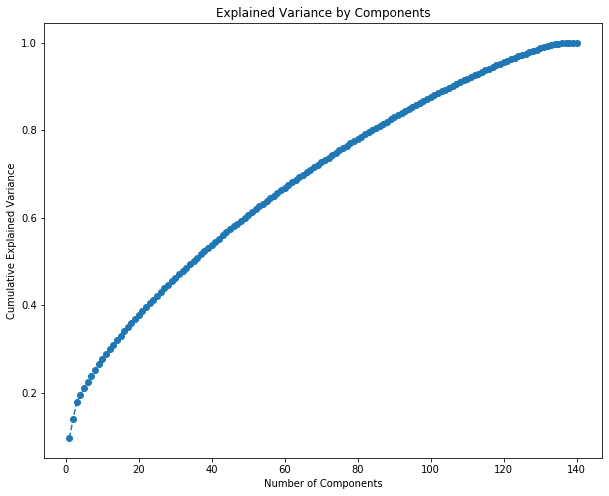

In [123]:
plt.figure(figsize = (10,8))
len_rat = len(pca.explained_variance_ratio_)+ 1
plt.plot(range(1, len_rat), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

### We want to keep around 80% of the variance- so choose 100

In [142]:
n_components = 90 #try a lower number since we have SO many
pca = PCA(n_components = n_components)
pca.fit(segmentation_std)
scores_pca = pca.transform(segmentation_std)

### Kmeans with PCA

In [143]:
#test number of clusters
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)


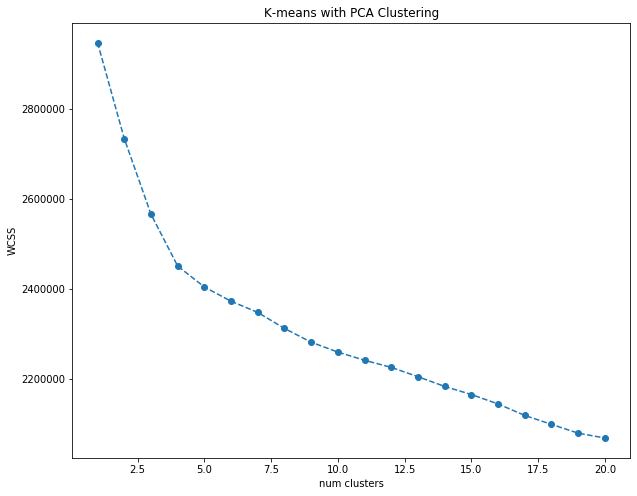

In [144]:
plt.figure(figsize = (10,8))
plt.plot(range(1,21), wcss, marker = 'o', linestyle = '--')
plt.xlabel('num clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [165]:
## Pick the elbow from above- about 5?
## And fit!
n_clusters = 6 ##trying 6 for 6 methods death
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [166]:
#put the components and clusters into one big dataframe
df_segm_pca_kmeans = pd.concat([dfrows.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-n_components:] = ["Component " + str(i) for i in range(1, n_components + 1)]
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [167]:
df_segm_pca_kmeans.head()

,RedCapID,CaseCtrl,indexredcapid,Female,Age,Race,Spanish,Month_Birth,Year_Birth,Month_Death,...,Component 82,Component 83,Component 84,Component 85,Component 86,Component 87,Component 88,Component 89,Component 90,Segment K-means PCA
0,25,0,1221372,1.0,98.564380,5.0,0.0,9.0,1903.0,4.0,...,-0.150942,0.302425,-0.161249,0.116543,0.107629,-0.240426,0.174806,-0.168006,0.145978,0
1,210,0,1229858,0.0,88.608220,5.0,0.0,6.0,1918.0,1.0,...,0.307347,0.247020,-0.090813,0.033233,-0.239290,-0.272377,0.283547,-0.426045,0.421926,0
2,500,0,1235588,1.0,35.039304,5.0,0.0,7.0,1957.0,1.0,...,-0.452179,-0.045538,-0.140701,0.052214,0.113734,-0.101762,-0.079484,0.073639,-0.030594,0
3,507,0,1220463,0.0,35.039304,5.0,0.0,10.0,1938.0,1.0,...,-0.000432,-0.068521,-0.121508,-0.027269,-0.297634,-0.216037,0.070900,-0.283866,0.343947,0
4,610,0,1219461,1.0,35.039304,5.0,0.0,7.0,1950.0,1.0,...,-0.483474,-0.068898,-0.212619,0.032527,-0.019793,-0.224931,-0.045679,-0.066902,0.147247,0


In [168]:
#Look at it!
import seaborn as sns

#map the color features
df_segm_pca_kmeans['deathmeth'] = df_segm_pca_kmeans['methoddeath'].map({-1: 'n/a',
                                                                            1: 'gun-related',
                                                                            2: 'asphyxiation',
                                                                            3: 'overdose',
                                                                            4: 'violent trauma',
                                                                            7: 'other'
                                                                        })
df_segm_pca_kmeans['segment'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0: 'first',
                                                                            1: 'second',
                                                                            2: 'third',
                                                                            3: 'fourth',
                                                                            4: 'fifth',
                                                                            5: 'sixth'
                                                                        })

x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['segment'])
plt.title('Clusters by PCA Components')
plt.show()

x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['deathmeth'])
plt.title('Clusters by methoddeath')
plt.show()

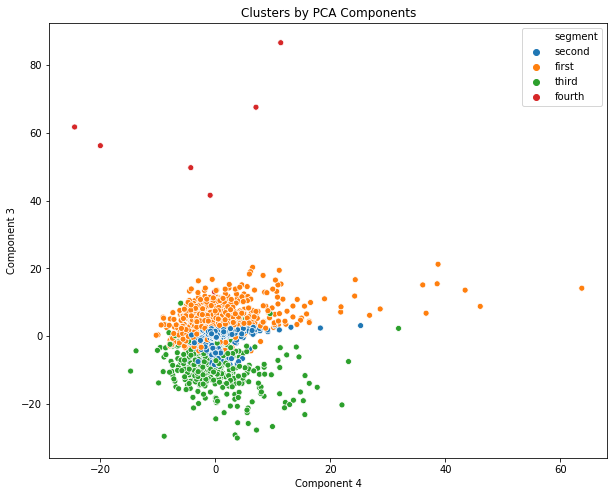

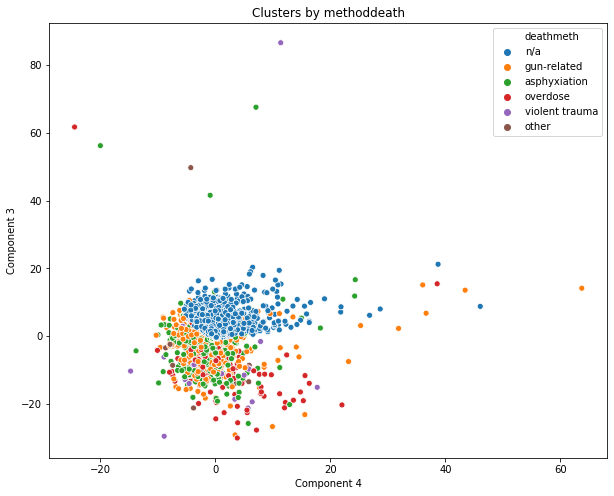

In [ ]:
#try some more components views
x_axis = df_segm_pca_kmeans['Component 4']
y_axis = df_segm_pca_kmeans['Component 3']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['segment'])
plt.title('Clusters by PCA Components')
plt.show()

x_axis = df_segm_pca_kmeans['Component 4']
y_axis = df_segm_pca_kmeans['Component 3']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_kmeans['deathmeth'])
plt.title('Clusters by methoddeath')
plt.show()

In [150]:
#Check out what the cluster distributions look like
features = ['CaseCtrl', 'Female', 'Age', 'Race',
       'Spanish', 'Month_Birth', 'Year_Birth', 'Month_Death',
       'Year_Death', 'EducationMax', 'EgoMaritalStatus', 'methoddeath',
       'violent']
df_segm_pca_kmeans[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").mean()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,0.149705,0.165805,35.640241,5.158115,-0.142510,2.456806,1.934569,-0.474569
1,1.000000,0.341176,21.778541,5.047059,0.200000,1.717647,2.447059,2.576471
2,1.000000,0.251870,20.796810,5.052369,0.182045,1.770574,2.458853,1.922693
3,0.073370,0.282609,35.217202,5.065217,0.190217,2.073370,2.040761,-0.679348
4,0.169803,0.203262,32.315640,5.162693,0.017148,2.035550,2.092848,-0.521121
5,1.000000,0.428571,23.922504,5.142857,0.142857,1.857143,3.285714,3.142857


In [151]:
#check the medians- better idea of centerpoints
df_segm_pca_kmeans[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").median()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
1,1,0.0,22.000000,5.0,0.0,2.0,2.0,3.0
2,1,0.0,21.000000,5.0,0.0,2.0,2.0,2.0
3,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
4,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
5,1,0.0,25.000000,5.0,0.0,2.0,4.0,2.0


In [152]:
#cluster sizes
for i in np.unique(kmeans_pca.labels_):
    print(i, len(kmeans_pca.labels_[kmeans_pca.labels_ == i])/len(kmeans_pca.labels_))

0 0.8724155518066617
1 0.0033347718623720035
2 0.015732276668366747
3 0.014437600533563497
4 0.09380517085801718
5 0.0002746282710188709


## Hierarchical Clustering

In [153]:
#do the clustering
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(scores_pca)

array([1, 1, 1, ..., 2, 1, 2], dtype=int64)

In [154]:
df_segm_pca_agclust = pd.concat([dfrows.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_agclust.columns.values[-n_components:] = ["Component " + str(i) for i in range(1, n_components + 1)]
df_segm_pca_agclust['Segment K-means PCA'] = cluster.labels_

In [155]:
df_segm_pca_agclust.head()

,RedCapID,CaseCtrl,indexredcapid,Female,Age,Race,Spanish,Month_Birth,Year_Birth,Month_Death,...,Component 82,Component 83,Component 84,Component 85,Component 86,Component 87,Component 88,Component 89,Component 90,Segment K-means PCA
0,25,0,1221372,1.0,98.564380,5.0,0.0,9.0,1903.0,4.0,...,-0.150942,0.302425,-0.161249,0.116543,0.107629,-0.240426,0.174806,-0.168006,0.145978,1
1,210,0,1229858,0.0,88.608220,5.0,0.0,6.0,1918.0,1.0,...,0.307347,0.247020,-0.090813,0.033233,-0.239290,-0.272377,0.283547,-0.426045,0.421926,1
2,500,0,1235588,1.0,35.039304,5.0,0.0,7.0,1957.0,1.0,...,-0.452179,-0.045538,-0.140701,0.052214,0.113734,-0.101762,-0.079484,0.073639,-0.030594,1
3,507,0,1220463,0.0,35.039304,5.0,0.0,10.0,1938.0,1.0,...,-0.000432,-0.068521,-0.121508,-0.027269,-0.297634,-0.216037,0.070900,-0.283866,0.343947,1
4,610,0,1219461,1.0,35.039304,5.0,0.0,7.0,1950.0,1.0,...,-0.483474,-0.068898,-0.212619,0.032527,-0.019793,-0.224931,-0.045679,-0.066902,0.147247,1


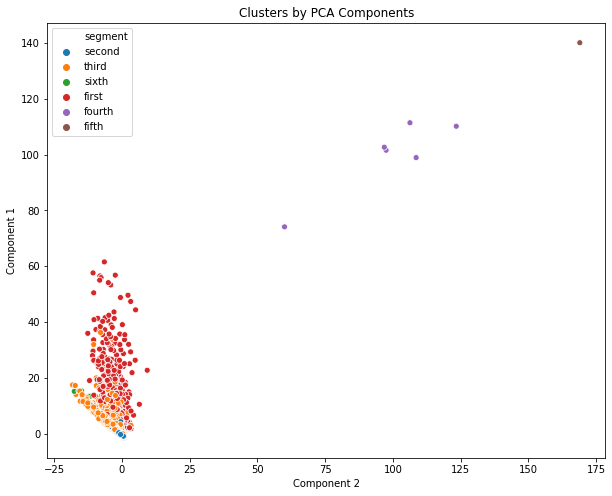

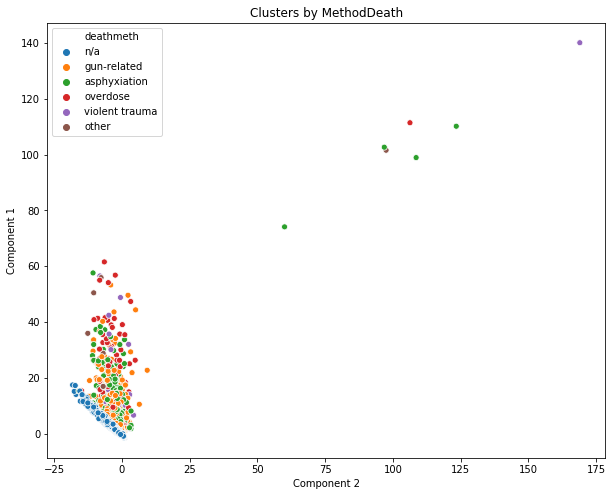

In [156]:
df_segm_pca_agclust['deathmeth'] = df_segm_pca_agclust['methoddeath'].map({-1: 'n/a',
                                                                            1: 'gun-related',
                                                                            2: 'asphyxiation',
                                                                            3: 'overdose',
                                                                            4: 'violent trauma',
                                                                            7: 'other'
                                                                        })
df_segm_pca_agclust['segment'] = df_segm_pca_agclust['Segment K-means PCA'].map({0: 'first',
                                                                            1: 'second',
                                                                            2: 'third',
                                                                            3: 'fourth',
                                                                            4: 'fifth',
                                                                            5: 'sixth'
                                                                        })

x_axis = df_segm_pca_agclust['Component 2']
y_axis = df_segm_pca_agclust['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_agclust['segment'])
plt.title('Clusters by PCA Components')
plt.show()

x_axis = df_segm_pca_agclust['Component 2']
y_axis = df_segm_pca_agclust['Component 1']
plt.figure(figsize = (10,8))
sns.scatterplot(x_axis, y_axis, hue=df_segm_pca_agclust['deathmeth'])
plt.title('Clusters by MethodDeath')
plt.show()

In [157]:
for i in np.unique(cluster.labels_):
    print(i, len(cluster.labels_[cluster.labels_ == i])/len(cluster.labels_))


0 0.022244889952528542
1 0.852642316293303
2 0.12405351328023853
3 0.0002353956608733179
4 3.9232610145552985e-05
5 0.0007846522029110596


In [158]:
#check out the cluster means
df_segm_pca_agclust[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").mean()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,1.000000,0.253968,20.681350,5.029982,0.158730,1.758377,2.460317,2.015873
1,0.139925,0.160769,35.848656,5.161690,-0.142548,2.461050,1.931211,-0.500253
2,0.201771,0.242884,31.975640,5.133776,0.012018,2.083175,2.076218,-0.421252
3,1.000000,0.333333,24.076255,5.166667,0.166667,2.000000,3.166667,3.000000
4,1.000000,1.000000,23.000000,5.000000,0.000000,1.000000,4.000000,4.000000
5,0.100000,0.050000,50.860605,5.000000,0.100000,2.400000,1.850000,0.100000


In [159]:
#cluster medians
df_segm_pca_agclust[["Segment K-means PCA", "CaseCtrl", "Female", "Age", "Race", "Spanish", "EducationMax", "EgoMaritalStatus", "methoddeath"]].groupby("Segment K-means PCA").median()


,CaseCtrl,Female,Age,Race,Spanish,EducationMax,EgoMaritalStatus,methoddeath
Segment K-means PCA,,,,,,,,
0,1,0.0,21.000000,5.0,0.0,2.0,2.0,2.0
1,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
2,0,0.0,35.039304,5.0,0.0,2.0,2.0,-1.0
3,1,0.0,25.000000,5.0,0.0,2.0,3.5,2.0
4,1,1.0,23.000000,5.0,0.0,1.0,4.0,4.0
5,0,0.0,39.500000,5.0,0.0,2.0,2.0,-1.0
